In [1]:
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

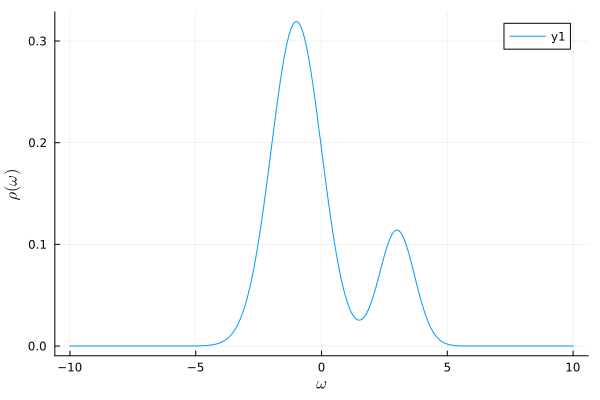

In [16]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = 0.8*gaussian(omega, -1.0, 1.0) + 0.2*gaussian(omega, 3, 0.7)
omegas = LinRange(-10, 10, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
f64_input_smpl = ComplexF64.(input_smpl)
f64_input_gw   = ComplexF64.(input_gw)
;

In [7]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [8]:
#construct solver struct
@time sol     = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
@time f64_sol = Nevanlinna.NevanlinnaSolver(f64_input_smpl, f64_input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 31
H=1
Iter     Function value   Gradient norm 
     0     4.484617e+00     1.538610e+01
 * time: 0.0178070068359375
     1     2.969888e+00     7.007199e+00
 * time: 1.0468900203704834
     2     2.597446e+00     6.182398e+00
 * time: 1.2301690578460693
     3     9.903298e-01     2.645353e+00
 * time: 1.4382719993591309
     4     7.660648e-01     1.434315e+00
 * time: 1.6508359909057617
     5     7.505472e-01     2.641496e-01
 * time: 1.8507740497589111
     6     7.501725e-01     3.686469e-02
 * time: 1.9558420181274414
     7     7.501647e-01     7.007489e-03
 * time: 2.1488358974456787
     8     7.501644e-01     1.114037e-03
 * time: 2.284364938735962
     9     7.501644e-01     1.376486e-04
 * time: 2.4194490909576416
    10     7.501644e-01     2.886053e-05
 * time: 2.550755023956299
    11     7.501644e-01     2.427034e-06
 * time: 2.7242441177368164
    12     7.501644e-01     8.752176e-07
 * time: 2.8395280838012695
    13     7.501644e-01     1.828093e

In [9]:
#execute optimize
@time Nevanlinna.solve!(sol)
@time Nevanlinna.solve!(f64_sol)

H=1
Iter     Function value   Gradient norm 
     0     7.501644e-01     7.970940e-09
 * time: 4.7206878662109375e-5
max_theta=0.2752789794177825939374062585260112435598
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     7.501644e-01     3.587271e+00
 * time: 0.0002200603485107422
     1     6.945387e-01     2.140135e+00
 * time: 0.15805292129516602
     2     6.522019e-01     1.889094e+00
 * time: 0.2622089385986328
     3     5.559737e-01     2.278295e+00
 * time: 0.41920995712280273
     4     3.278326e-01     3.004155e+00
 * time: 0.5214459896087646
     5     2.725347e-01     4.343055e-01
 * time: 0.6240439414978027
     6     2.676918e-01     2.171295e-01
 * time: 0.7214269638061523
     7     2.666345e-01     4.935962e-02
 * time: 0.8177030086517334
     8     2.666038e-01     9.899943e-03
 * time: 0.9632489681243896
     9     2.666019e-01     5.026237e-03
 * time: 1.1099450588226318
    10     2.666015e-01     2.049533e-03
 * time: 1.254646

In [10]:
wo_sol = NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
f64_wo_sol = Nevanlinna.NevanlinnaSolver(f64_input_smpl, f64_input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31
N_imag is setted as 15


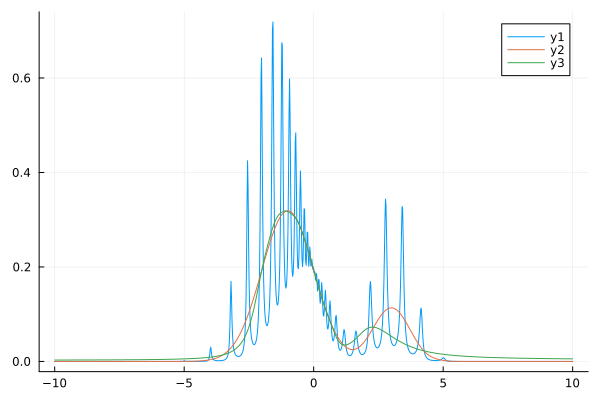

In [11]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
#plot!(real.(f64_wo_sol.reals.freq), imag.(f64_wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(Float64.(real.((f64_sol.reals.freq))), Float64.(imag.(f64_sol.reals.val))/pi)
#plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [22]:
plot(xlim = [-6,6],
    size = (540,400),
    legend = :topright,
    xticks = [5,0,-5],
    legendfont=font(12, "Times"),
    guidefont=font(22), 
    xtickfont=font(15, "Times"), 
    ytickfont=font(15, "Times"), 
    ylabel=latexstring("\\rho(\\omega)"),
    xlabel=latexstring("\\omega"),
    framestyle=:box,
)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt 128bit",lw=5)
plot!(Float64.(real.((f64_sol.reals.freq))), Float64.(imag.(f64_sol.reals.val)/pi),label="opt 64bit",lw=5)
plot!(omegas, rho.(omegas), label="exact",lw=2.5, ls=:dash,lc=:black)

savefig("data/two_peak_presicion.svg")

"/home/kosuke/work/Nevanlinna.jl/notebooks/data/two_peak_presicion.svg"